In [27]:
import zipfile
zipf = zipfile.ZipFile('/content/drive/MyDrive/dip_project/archive (1).zip')
zipf.extractall('/content/drive/MyDrive/dip_project')

In [1]:
## Imports ##
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from IPython.display import clear_output
%cd /content/drive/MyDrive/dip_project

/content/drive/MyDrive/dip_project


In [3]:
SOURCE_IMAGE = cv2.cvtColor(cv2.imread('./Lenna_(test_image).png'), cv2.COLOR_BGR2RGB)

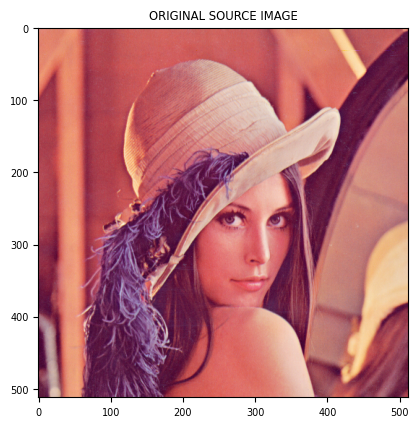

In [4]:
plt.rc("font", size=7)
plt.title("ORIGINAL SOURCE IMAGE");plt.imshow(SOURCE_IMAGE)

In [5]:
RESIZED_SOURCE_IMAGE = cv2.resize(SOURCE_IMAGE, (128, 128))

In [6]:
RESIZED_SOURCE_IMAGE.shape

(128, 128, 3)

#### `JPEG Image Compression & Quantization Code From Scratch (=Making the k-space JPEG codes)`

In [7]:
from scipy.fftpack import dct ## Returns the Discrete Cosine Transform of arbitrary type sequence x

### (1) Divide the image to patches with size 8x8
## (2) Apply the DCT to all of the patches
def img2_DCT_patch(img, patch_size=8, use_yuv=False):
  H, W, C = img.shape
  if use_yuv:
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)

  assert (H % patch_size == 0) & (W % patch_size == 0)
  dct_img = np.zeros_like(img)

  for h in range(0, H, patch_size):
    for w in range(0, W, patch_size):
      for c in range(0, C):
        ## Before DCT on the block,values are shifted from a positive range to one centeed on zero
        # arr_2d = img[h:h+patch_size, w:w+patch_size, c]  - 128 ## DCT가 scipy 라이브러리에서 1D만 지원을 하는 상황이기 때문에 1D로 reshape -> 1D DCT -> 2D로 reshape의 과정을 거친다.
        arr_2d = img[h:h + patch_size, w:w+patch_size, c]
        arr_1d = arr_2d.reshape(patch_size**2)
        # dct_arr = dct(arr_1d).real
        # dct_arr = cv2.dct(arr_2d - 128)
        dct_arr = cv2.dct(arr_2d)
        dct_img[h:h+patch_size, w:w+patch_size, c] = dct_arr # .reshape(patch_size, patch_size)
  return dct_img



In [8]:
def min_max_scale(img):
  M, m = np.max(img), np.min(img)
  return (img - m) / (M-m)

In [9]:
# dct_img = img2_DCT_patch(SOURCE_IMAGE.astype(np.float32), 8, False)
dct_img = img2_DCT_patch(RESIZED_SOURCE_IMAGE.astype(np.float32), 8, False)

In [11]:
print(dct_img.max(), dct_img.min())

1909.6249 -454.6114


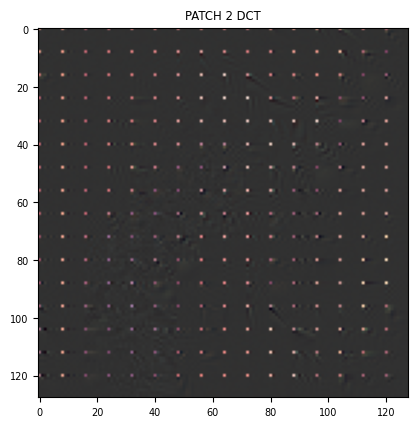

In [10]:
plt.rc("font", size=7)
plt.title("PATCH 2 DCT");plt.imshow(min_max_scale(dct_img) )

In [12]:
QUANTIZE_MAT = np.array([
   [16,11,10,16,24,40,51,61],
    [12,12,14,19,26,58,60,55],
    [14,13,16,24,40,57,69,56],
    [14,17,22,29,51,87,80,62],
    [18,22,37,56,68,109,103,77],
    [24,35,55,64,81,104,113,92],
    [49,64,78,87,103,121,120,101],
    [72,92,95,98,112,100,130,99]
])

- `JPEG` quantization 과정에서는 k-space JPEG code가 고주파 성분은 저장하고 spectral space information은 제외를 한다.
- 만약에 DCT의 결과의 왼쪽 위의 값만 사용을 한다고 하면 이는 DC,즉 direct current term이며, 전체 픽셀 값들의 평균이 된다.
  - 나머지 값들인 AC 값들은 평균에 독립적이다. 그래서 만약에 원래 이미지에 같은 수를 더하거나 뺴면 오직 DC값만 바뀌게 될 것이다.
  - 따라서 DC값만을 사용하면 전체 이미지의 1./8의 resolution 이미지 정보가 남게 된다.

In [13]:
### (3) Apply thresholding and quantization to the JPEG Image
def thresh_quant(img, patch_size=8):
  H, W, C = img.shape
  quantized = np.zeros_like(img)
  for h in range(0, H, patch_size):
    for w in range(0, W, patch_size):
      for c in range(C):
        temp = img[h:h+patch_size, w:w+patch_size, c] / QUANTIZE_MAT
        temp = np.around(temp) ## Quantizing process with the QUANTIZE MATRIX takes the DC values from the quantized matrices, which makes
        # us end up with 1/8 th resolution of the original image
        quantized[h:h+patch_size, w:w+patch_size, c] = temp
  return quantized

  

In [14]:
quantized = thresh_quant(dct_img, 8)

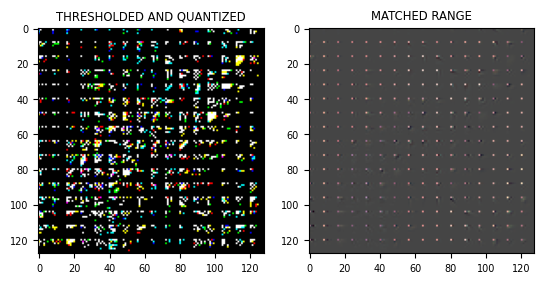

In [15]:
plt.rc("font", size=7)
plt.subplot(1, 2, 1);plt.title("THRESHOLDED AND QUANTIZED");plt.imshow(quantized)
plt.subplot(1, 2, 2);plt.title("MATCHED RANGE");plt.imshow((quantized-quantized.min()) / (quantized.max() - quantized.min()) )

In [16]:
## (4) Inverse Discrete Cosine Transform
from scipy.fftpack import idct

def inverse_dct(img, patch_size=8):
  idct_img = np.zeros_like(img)
  H, W, C = img.shape
  for h in range(0, H, patch_size):
    for w in range(0, W, patch_size):
      for c in range(C):
        arr_2d = img[h:h+patch_size, w:w+patch_size, c]
        arr_1d = arr_2d.reshape(patch_size**2)
        # idct_1d = idct(arr_1d, norm='ortho').real
      
        idct_img[h:h+patch_size, w:w+patch_size, c] = cv2.idct(arr_2d) # idct_1d.reshape(patch_size, patch_size)

  return idct_img

In [17]:
idct_img = inverse_dct(quantized, 8)

In [18]:
def to_rgb(img):
  M, m = img.max(), img.min()
  mm_scaled = (img - m) / (M-m)
  return mm_scaled

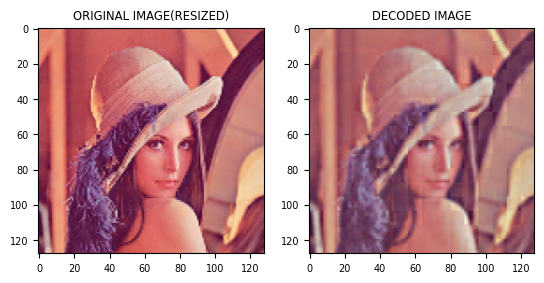

In [19]:
rgb = to_rgb(idct_img)

plt.subplot(1, 2, 1);plt.title("ORIGINAL IMAGE(RESIZED)");plt.imshow(RESIZED_SOURCE_IMAGE);
plt.subplot(1, 2, 2);plt.title("DECODED IMAGE");plt.imshow(rgb);

### `Heterogeneous Residual Convolutional Neural Network`

In [1]:
## Imports ##
import cv2
import numpy as np
import matplotlib.pyplot as plt
import math
from IPython.display import clear_output
%cd /content/drive/MyDrive/dip_project

/content/drive/MyDrive/dip_project


#### `DataLoaders`

In [2]:
import cv2
import matplotlib.pyplot as plt
import glob

train_files = glob.glob('./DIV2K_train_HR/DIV2K_train_HR/*.png')
print(len(train_files))

800


IMAGE SHAPE : (1404, 2040, 3)


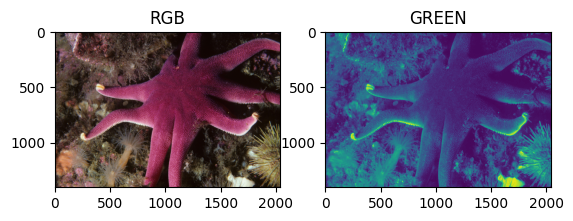

In [3]:
img = cv2.imread(train_files[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.subplot(1,2, 1);plt.title("RGB");plt.imshow(img)
plt.subplot(1, 2, 2);plt.title("GREEN");plt.imshow(img[:, :, 1])
print(f"IMAGE SHAPE : {img.shape}")

In [4]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

import os
import numpy as np
import cv2

QUANTIZE_MAT = np.array([
   [16,11,10,16,24,40,51,61],
    [12,12,14,19,26,58,60,55],
    [14,13,16,24,40,57,69,56],
    [14,17,22,29,51,87,80,62],
    [18,22,37,56,68,109,103,77],
    [24,35,55,64,81,104,113,92],
    [49,64,78,87,103,121,120,101],
    [72,92,95,98,112,100,130,99]
])

def mm_scale(img):
  M, m = img.max(), img.min()
  return (img - m) / (M-m)

class HRCNNDataset(Dataset):
  def __init__(self, args, mode='train'):
    super(HRCNNDataset, self).__init__()
    self.args = args
    self.mode = mode ## train or valid

    self._init_files()
  
  def _init_files(self):
    data_path = os.path.join(self.args.base_path, f"DIV2K_{self.mode}_HR", f"DIV2K_{self.mode}_HR")
    files = glob.glob(data_path + "/*.png")
    
    self.files = files

  
  def _make_Kspace_code_single(self, patch):
    dct_patch = cv2.dct(patch)
    quantized_patch = np.divide(dct_patch, QUANTIZE_MAT)
    quantized_patch = np.around(quantized_patch)

    return quantized_patch
  
  def _make_Kspace_code_multi(self, croped_image):
    patch_size = self.args.patch_size
    new_image = np.zeros_like(croped_image)
    H, W = croped_image.shape
    assert (H % patch_size == 0) & (W % patch_size == 0)

    for h in range(0, H, patch_size):
      for w in range(0, W, patch_size):
        patch = croped_image[h:h+patch_size, w:w+patch_size]
        new_image[h:h+patch_size, w:w+patch_size] = self._make_Kspace_code_single(patch)

    return new_image



  def _make_patches(self, img, entire=False):
    """
    :img numpy.array type image read with cv2 
    """
    image_size = self.args.image_size
    if entire:
      H, W = img.shape
      if ((H % image_size == 0) & (W % image_size == 0)) == False:
        new_h = image_size * math.floor(H / image_size)
        new_w = image_size * math.floor(W / image_size)
        img = cv2.resize(img, (new_w, new_h))
        H, W = new_h, new_w
        print(f"RESIZED IMAGE TO MATCH THE IMAGE CROP SIZE : {img.shape}")

      patches = [] # np.empty((0, image_size, image_size))
      org_images = [] # np.empty((0, image_size, image_size))

      for h in range(0, H, image_size):
        for w in range(0, W, image_size):
          temp = img[h:h+image_size, w:w+image_size]
          temp_dct = self._make_Kspace_code_multi(temp)
          # print(temp_dct.shape)

          # np.append(patches, np.expand_dims(temp_dct, 0), axis=0)
          # np.append(org_images, np.expand_dims(temp, 0), axis=0)
          patches.append(np.expand_dims(temp_dct, -1))
          org_images.append(np.expand_dims(temp, -1))
          # print(patches.shape)

      patches = np.stack(patches, axis=-1) # np.concatenate(patches, 0)
      org_images = np.stack(org_images, axis=-1) # np.concatenate(org_images, 0)np
      
      patches, org_images = np.squeeze(patches, -2), np.squeeze(org_images, -2)
      print(patches.shape, org_images.shape)
      return patches, org_images, H, W

    else:
      H, W = img.shape
      h = np.random.choice(range(image_size // 2, H - image_size//2))
      w = np.random.choice(range(image_size // 2, W - image_size//2))
      patch = img[h-image_size//2:h+image_size//2, w-image_size//2:w+image_size//2]
     
      dct_patch = self._make_Kspace_code_multi(patch)

      return dct_patch, patch



  def __len__(self):
    if self.mode == 'train':
      return self.args.repeat * len(self.files)
    else:
      return len(self.files)
  
  def _mm_scale(self, img):
    M, m = img.max(), img.min()
    if (M-m) != 0 and (M-m)!=0.:
      return (img - m) / (M-m)
    else:
      return img

  def __getitem__(self, idx):
    idx %= len(self.files)
    fpath = self.files[idx]

    img = cv2.imread(fpath)

    if self.args.rgb:
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = img[:, :, 1] ### For RGB images, let's only select the Green Channel
    else:
      img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY) ### Otherwise, let's use the Gray Channel
    
    img = img.astype(np.float32)
    ## MIN-MAX SCALE!!! Onlyt the target 
    if self.mode == 'train':
      patch, orig = self._make_patches(img, entire=False)
    else:
      patch, orig, H, W = self._make_patches(img, entire=True)
    
    orig = self._mm_scale(orig)
    # patch = self._mm_scale(patch)
    aug = transforms.ToTensor()
    patch_tensor = aug(patch)
    orig_tensor = aug(orig)
    

    if self.mode == 'valid':
      return patch_tensor, orig_tensor, (H, W), fpath
    else:
      return patch_tensor, orig_tensor    


PATCH SHAPE TRAIN: torch.Size([4, 1, 128, 128])  ORIG SHAPE TRAIN: torch.Size([4, 1, 128, 128])
RESIZED IMAGE TO MATCH THE IMAGE CROP SIZE : (1536, 1920)
(128, 128, 180) (128, 128, 180)
[tensor([1536]), tensor([1920])]
PATCH SHAPE TRAIN: torch.Size([1, 180, 128, 128])  ORIG SHAPE TRAIN: torch.Size([1, 180, 128, 128])


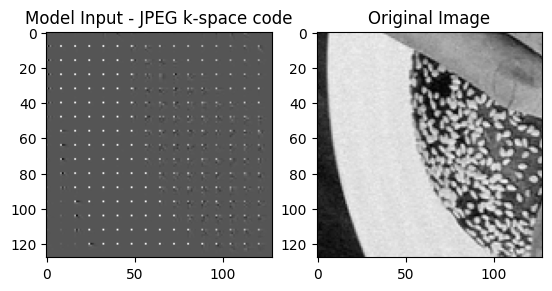

In [5]:
class Args(object):
  def __init__(self):
    super(Args, self).__init__()
    self.patch_size = 8
    self.image_size = 128
    self.base_path = '/content/drive/MyDrive/dip_project'
    self.repeat = 8
    self.rgb = True

if __name__ == "__main__":
  args = Args()
  train_dataset = HRCNNDataset(args, mode='train')
  test_dataset = HRCNNDataset(args, mode='valid')

  train_dataloader = DataLoader(train_dataset, batch_size=4, shuffle=True)
  test_dataloader = DataLoader(test_dataset, batch_size = 1, shuffle=True)

  for idx, batch in enumerate(train_dataloader):
    train_patch, train_orig = batch
    print(f"PATCH SHAPE TRAIN: {train_patch.shape}  ORIG SHAPE TRAIN: {train_orig.shape}")
    break
  
  for idx, batch in enumerate(test_dataloader):
    patch, orig, size, fpath = batch
    print(size)
    print(f"PATCH SHAPE TRAIN: {patch.shape}  ORIG SHAPE TRAIN: {orig.shape}")
    break

  plt.subplot(1, 2, 1);plt.title("Model Input - JPEG k-space code");plt.imshow(patch[0, 77, :, :].detach().cpu().numpy(), cmap = 'gray')
  plt.subplot(1, 2, 2);plt.title("Original Image");plt.imshow(mm_scale(orig[0, 77, :, :].detach().cpu().numpy()), cmap = 'gray')



In [6]:
def patch2image(patches, original_size):
  C, B, H, W = patches.shape
  orgH, orgW = original_size
  if isinstance(orgH, torch.Tensor):
    orgH, orgW = int(orgH), int(orgW)
  image = np.zeros((orgH, orgW))
  sliceH, sliceW = orgH // H, orgW // W

  idx = 0
  for h in range(0, orgH, H):
    for w in range(0, orgW, W):
      temp = patches[:, idx, :, :].detach().cpu().numpy()
      image[h:h+H, w:w+W] = temp
      idx += 1
  return image



In [7]:
image = patch2image(orig, size)

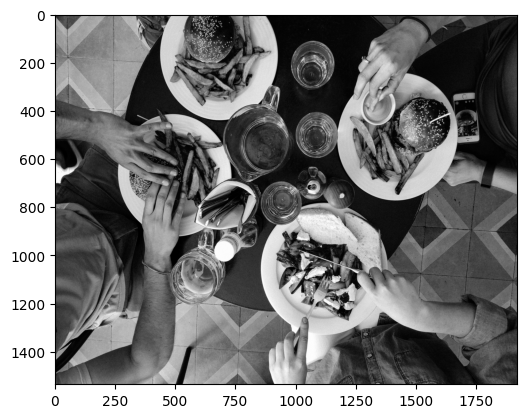

In [8]:
plt.imshow(image, cmap = 'gray')

#### `Network`

1. `Channel Splitter`
- 64 Binary coded masks are used for the convolution kernel.
- This layer extracts the spectral samples in X channel by channel, and represents them as a set of spectral space snapshots.
- `weight`:  (out_ch, in_ch, kernel_h, kernel_w)

In [9]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ChannelSplitter(nn.Module):
  def __init__(self, in_ch, patch_size, use_bias=False):
    super(ChannelSplitter, self).__init__()
    self.patch_size = patch_size 
    self.kernel = torch.zeros((patch_size * patch_size, in_ch, patch_size, patch_size), requires_grad=False, dtype=torch.float32) ## [OutCH, InCH, KH, KW]

    for i in range(patch_size * patch_size):
      h, w = i // patch_size, i % patch_size
      self.kernel[i, 0, h, w] = 1
    self.kernel = nn.Parameter(self.kernel, requires_grad=False)
    if use_bias:
      self.bias = torch.ones((patch_size * patch_size), requires_grad=False)
    else:
      self.bias=None
  
  def forward(self, x):
    out = F.conv2d(
        x, self.kernel, self.bias, stride=self.patch_size, groups=1
    )
    return out



In [10]:
if __name__ == "__main__":
  layer = ChannelSplitter(in_ch=1, patch_size=8, use_bias=False)
  out1 = layer(patch[:, 77, :, :].unsqueeze(1))
  print(out1.shape)

torch.Size([1, 64, 16, 16])


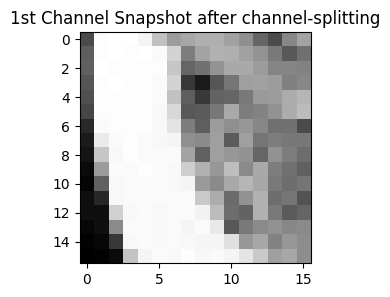

In [11]:
plt.figure(figsize = (3,3));
plt.title("1st Channel Snapshot after channel-splitting")
plt.imshow(out1[0, 0, :, :].detach().cpu().numpy(), cmap = 'gray')

2. `Spectral Snapshot Reconstruction`
- The snapshots at each spectral channel are reconstructed to the same dimension as that of the original image in this layer.
- (B, 64, 16, 16) -> (B, 64, H, W)
- 원래 JPEG compression을 수행하는 과정에서 quantizing 때문에 macroblocking artifact가 생기는 것인데, 이를 해결하기 위해서 decoding과 artifact suppression 단계 전에 원래 size로 `transposed conv`를 사용해서 키워준다.
- **This step performs an inverse operation of compression and restores the one-to-many positional connectivity**

In [12]:
import torch
import torch.nn as nn

class SSRecon(nn.Module):
  def __init__(self, in_ch, out_ch, kernel_size=8):
    super(SSRecon, self).__init__()
    self.dconv = nn.ConvTranspose2d(in_ch, out_ch, kernel_size=kernel_size, stride=kernel_size, 
                                    padding=0, output_padding=0, dilation=1, bias=True)
    self._init_weight(self.dconv)

  def _init_weight(self, m):
    if isinstance(m, nn.ConvTranspose2d):
      nn.init.xavier_uniform_(m.weight)
      m.bias.data.fill_(0.01)

  def forward(self, x):
    out = self.dconv(x)
    return out

In [13]:
if __name__ == "__main__":
  layer = SSRecon(64, 64, 8)
  out2 = layer(out1)
  print(out2.shape)

torch.Size([1, 64, 128, 128])


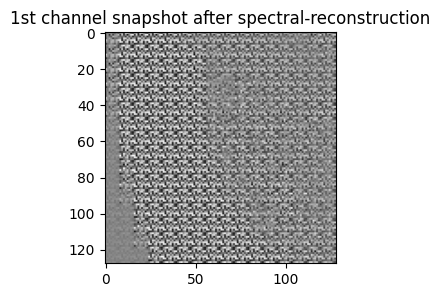

In [14]:
plt.figure(figsize = (3,3))
plt.title("1st channel snapshot after spectral-reconstruction")
plt.imshow(out2[0, 0, :, :].detach().cpu().numpy(), cmap = 'gray')

3.  `Decoding and Macroblocking Artifacts Suppression`
- 앞선 단계에서 spectral space sample을 enrich한 뒤에는 decoding process로 넘어가게 된다.
- 원래 JPEG decoding은 각 8x8 block에 IDCT를 적용하는 방법을 사용한다.
- 하지만 이렇게 하면 다른 spectral channel의 uncorrelated nature로 인해서 robust하다.
- (B, 64, H, W) -> (B, 8, H, W) -> (B, 1, H, W) + `ReLU`

In [15]:
import torch.nn as nn
import torch.nn.functional as F

class Decoder(nn.Module):
  def __init__(self, in_ch, mid_ch, out_ch):
    super(Decoder, self).__init__()
    ## TODO ##
    ## Check padding mode ##
    self.conv1 = nn.Conv2d(in_ch, mid_ch, kernel_size=5, stride=1, padding=2, dilation=1, bias=True, padding_mode='replicate')
    self.conv2 = nn.Conv2d(mid_ch, out_ch, kernel_size=3, stride=1, padding=1, dilation=1, bias=True, padding_mode='replicate')
    self._init_weight()
  
  def _init_weight(self):
    for param in self.parameters():
      if isinstance(param, nn.Conv2d):
        nn.init.xavier_uniform_(param.weight)
        param.bias.data.fill_(0.01)

  def forward(self, x):
    decoder_outputs = {}
    decoder_outputs['conv1'] = x
    x = self.conv1(x)
    decoder_outputs['conv2'] = x
    x = F.relu(self.conv2(x)) ##  ReLU Used for enforcing the non-negative regularization

    return x, decoder_outputs

In [16]:
if __name__ == "__main__":
  layer = Decoder(64, 8, 1)
  out3, decoder_outputs = layer(out2)
  print(out3.shape)

torch.Size([1, 1, 128, 128])


In [17]:
for key, value in decoder_outputs.items():
  print(value.shape)

torch.Size([1, 64, 128, 128])
torch.Size([1, 8, 128, 128])


In [18]:
out3.max(), out3.min()

(tensor(1.2111, grad_fn=<MaxBackward1>), tensor(0., grad_fn=<MinBackward1>))

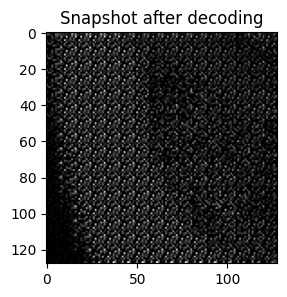

In [19]:
plt.figure(figsize=(3, 3))
plt.title("Snapshot after decoding")
plt.imshow(out3[0, 0, :, :].detach().cpu().numpy(), cmap = 'gray')

4. `Image Detail Sharpness Enhancement`
- 앞선 단계에서 pixel space의 macroblocking artifact를 suppress해 주었기 때문에 추가적으로 이미지 sharpness를 위해서는 detail도 recon해 주어야 한다.
- Residual connection과 cascaded convolutional을 사용해서 보완해 준다.

In [20]:
import torch.nn as nn
import torch.nn.functional as F

class Sharpener(nn.Module):
  def __init__(self, in_ch, channels = [64, 16, 1], kernels = [11, 7, 1]):
    super(Sharpener, self).__init__()
    channels.insert(0, in_ch)
    in_channels, out_channels = channels[:3], channels[1:]
    
    for n in range(4):
      temp = []
      for in_ch, out_ch, ksize in zip(in_channels, out_channels, kernels):
        ## TODO ##
        ## Check the padding mode ##
        temp.append(nn.Conv2d(
            in_ch, out_ch, kernel_size=ksize, stride=1, padding=ksize//2, dilation=1, bias=True, padding_mode='replicate'
        ))
      if n == 0:
        self.layer1 = nn.Sequential(*temp)
      elif n == 1:
        self.layer2 = nn.Sequential(*temp)
      elif n == 2:
        self.layer3= nn.Sequential(*temp)
      else:
        self.layer4=nn.Sequential(*temp)
    self._init_weight()

  def _init_weight(self):
    for param in self.parameters():
      if isinstance(param, nn.Conv2d):
        nn.init.xavier_uniform_(param.weight)
        param.bias.data.fill_(0.01)

  def forward(self, x):
    residual = x
    results = {}
    
    # for key, value in self.layer.items():
    for idx, layer in enumerate([self.layer1, self.layer2, self.layer3, self.layer4]):
      # for layer in value:
        # x = layer(x)
      x = layer(x)
      x += residual
      results[idx] = x
      residual = x
        
    x = F.relu(x) ## Enforces non-negative regularization and renders the neural network nonlinear processing capbility
    return x, results

In [21]:
if __name__ == "__main__":
  layer = Sharpener(1)
  out3.shape
  out4, residual_outputs = layer(out3)
  print(len(residual_outputs))
  print(out4.shape, out4.max(), out4.min())

4
torch.Size([1, 1, 128, 128]) tensor(1.3005, grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)


In [22]:
for key, value in residual_outputs.items():
  print(value.shape)

torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])
torch.Size([1, 1, 128, 128])


1.0 0.0
1.0 0.0


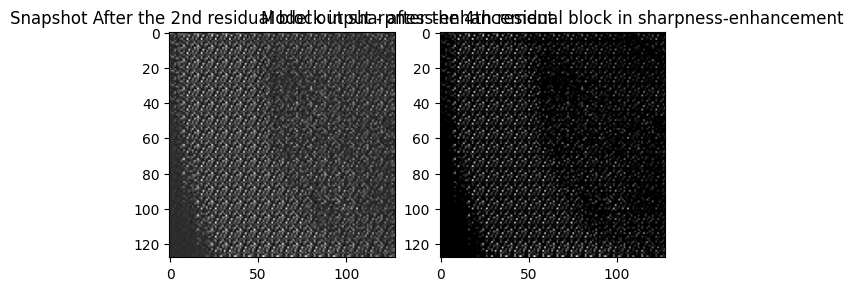

In [23]:
def scale(img):
  # img = img.detach().cpu().numpy()
  M, m = img.max(), img.min()
  if (M-m) != 0 and (M-m) != 0.:
    img = (img - m) / (M- m)
  print(img.max(), img.min())
  return img

# plt.figure(figsize=(4, 4))
plt.subplot(1, 2, 1);
plt.title("Snapshot After the 2nd residual block in sharpness-enhancement")
plt.imshow(scale(residual_outputs[1][0, 0, :, :].detach().cpu().numpy()), cmap = 'gray')


plt.subplot(1, 2, 2);plt.title("Model output - after the 4th residual block in sharpness-enhancement")
plt.imshow(scale(out4[0, 0, :, :].detach().cpu().numpy()), cmap = 'gray')

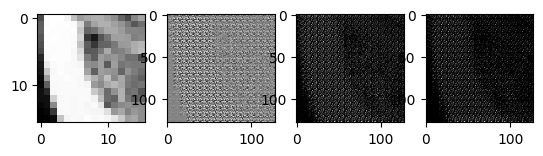

In [24]:
plt.subplot(1, 4, 1);plt.imshow(out1[0, 0, :, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(1, 4, 2);plt.imshow(out2[0, 0, :, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(1, 4, 3);plt.imshow(out3[0, 0, :, :].detach().cpu().numpy(), cmap='gray')
plt.subplot(1, 4, 4);plt.imshow(out4[0, 0, :, :].detach().cpu().numpy(), cmap='gray')


5. `Total Model`

In [28]:
import torch
import torch.nn as nn

class HRCNN(nn.Module):
  def __init__(self, in_ch, patch_size):
    super(HRCNN, self).__init__()
    self.channel_splitter = ChannelSplitter(in_ch=in_ch, patch_size=patch_size, use_bias=False)
    self.reconstructor = SSRecon(in_ch=64, out_ch=64, kernel_size=8)
    self.decoder = Decoder(in_ch=64, mid_ch=8, out_ch=1)
    self.enhancer = Sharpener(1)
  
  def forward(self, x):
    x = self.channel_splitter(x)
    # print(x.shape)
    x = self.reconstructor(x)
    # print(x.shape)
    x, decoder_outputs = self.decoder(x)
    # print(x.shape)
    x, residual_outputs = self.enhancer(x)

    return x, residual_outputs, decoder_outputs


In [30]:
if __name__ == "__main__":
  net = HRCNN(1, 8)
  pred, residual_outputs, decoder_outputs = net(train_patch)
  print(pred.shape, pred.max(), pred.min())

torch.Size([4, 1, 128, 128]) tensor(1.7095, grad_fn=<MaxBackward1>) tensor(0., grad_fn=<MinBackward1>)


In [31]:
test = pred[0][0].detach().cpu().numpy()
test = (test - test.min()) / (test.max() - test.min())
cv2.imwrite('/content/drive/MyDrive/dip_project/test.png', test * 255.)

True

#### `Loss Functions`

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
## Gram Matrix and Gram Loss

class GramMatrix(nn.Module):
    def forward(self, input):
        b,c,h,w = input.size()
        F = input.view(b, c, h*w)
        G = torch.bmm(F, F.transpose(1,2)) 
        G.div_(h*w)
        return G

class GramMSELoss(nn.Module):
    def forward(self, input, target):
        out = nn.MSELoss()(GramMatrix()(input), target)
        return(out)

In [33]:
import torch
import torch.nn as nn
import torchvision

### Content Loss with Pretrained VGG

class ContentLoss(nn.Module):
  def __init__(self, loss_fn, device):
    super(ContentLoss, self).__init__()
    self.criterion = loss_fn
    self.device = device
    self.net = self.content_model()
  
  def content_model(self):
    self.cnn = torchvision.models.vgg19(pretrained=True).features
    self.cnn.to(self.device)
    content_layers = ['relu_8']

    model = nn.Sequential()
    i = 0
    for layer in self.cnn.children():
      if isinstance(layer, nn.Conv2d):
        i += 1
        name = f"conv_{i}"
      elif isinstance(layer, nn.ReLU):
        name = f"relu_{i}"
        layer = nn.ReLU(inplace=False)
      elif isinstance(layer, nn.MaxPool2d):
        name = f"pool_{i}"
      elif isinstance(layer, nn.BatchNorm2d):
        name = f"bn_{i}"
      else:
        raise RuntimeError(f"UNRECOGNIZED LAYER: {layer.__class__.__name__}")
      model.add_module(name, layer)

      if name in content_layers:
        break
    return model
  
  def get_loss(self, predict, target):
    ## CAUTION ##
    ## The pretrained VGG19 takes 3-channel RGB images.
    ## Might not be that adjustable for 1-channels images.
    if predict.shape[1] == 1:
      predict = torch.cat((predict, predict, predict), 1)
    if target.shape[1] == 1:
      target = torch.cat((target, target, target), 1)
    pred_feature = self.net(predict)
    target_feature = self.net(target)
    loss = self.criterion(pred_feature, target_feature)

    return loss

#### `Training`

In [36]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD

from tqdm import tqdm
from skimage.metrics import peak_signal_noise_ratio
import numpy as np

def patch2image(patches, original_size):
  C, B, H, W = patches.shape
  orgH, orgW = original_size
  if isinstance(orgH, torch.Tensor):
    orgH, orgW = int(orgH), int(orgW)
  image = np.zeros((orgH, orgW))
  sliceH, sliceW = orgH // H, orgW // W

  idx = 0
  for h in range(0, orgH, H):
    for w in range(0, orgW, W):
      temp = patches[:, idx, :, :]
      image[h:h+H, w:w+W] = temp
      idx += 1
  return image

"""
def calculate_psnr(predict, target):

  # predict: np.array
  # target: np.array

  mse = np.square(np.subtract(predict, target)).mean()
  R = np.max(target) 
  if mse != 0 and mse != 0. and R != 0. and R != 0:
    psnr = 20 * np.log10(R**2 / math.sqrt(mse))
  else:
    # psnr = 10 * np.log10(R**2)
    psnr = 100
  return psnr
"""

def calculate_psnr(predict, target):
  return peak_signal_noise_ratio(target, predict)

def save_model(model, model_path, fname):
  pass


def to_save(arr):
  # arr = arr.astype(int)
  M, m = arr.max(), arr.min()
  if (M-m) != 0. and (M-m) != 0:
    mm_scaled = (arr-m)/ (M-m)
  else:
    mm_scaled = arr
  # mm_scaled = mm_scaled.astype(int)
  
  return mm_scaled * 255.

def validate(model, valid_dataloader, device, result_dir):
  valid_loop = tqdm(valid_dataloader)
  model.eval()
  print("VALIDATING...")
  ret_psnr = 0
  for idx, batch in enumerate(valid_loop):
    input, target, size, fpath = batch
    size = [int(a) for a in size]

    input = input.to(device);
    target = target.to(device);

    C, B, H, W = input.shape
    running_psnr_score = 0

    predicted_patches = np.zeros((C, B, H, W))

    for b in range(B):
      single_input = torch.unsqueeze(input[:, b, :, :], 0)
      single_target = torch.unsqueeze(target[:, b, :, :], 0)
      single_predict, residual_outputs, decoder_outputs = model(single_input) ## [1, 1, 128, 128]

      psnr_score = calculate_psnr(single_predict.detach().cpu().numpy(), single_target.detach().cpu().numpy())
      
      predicted_patches[0][b] = single_predict.squeeze(1).squeeze(0).detach().cpu().numpy()

      running_psnr_score += psnr_score

    running_psnr_score /= B ## 전체 큰 이미지 전체의 PSNR의 score이다. 왜냐면 작은 patch에 detail이 없으면 사실상 의미가 거의 없기 때문이다.
    predicted_patches = patch2image(predicted_patches, size)
    target_patches = patch2image(target.detach().cpu().numpy(), size)

    entire_psnr_score = calculate_psnr(predicted_patches, target_patches)
    ret_psnr += entire_psnr_score

    valid_loop.set_postfix({
        "Running PSNR": running_psnr_score, "Total PSNR": entire_psnr_score
    })

    cv2.imwrite(os.path.join(result_dir, os.path.basename(fpath[0])), to_save(predicted_patches))
    if idx % 10 == 0:
      clear_output(wait = True)
    # print(to_save(predicted_patches).max())
  model.train()
  return ret_psnr / len(valid_loop), model





def train(model, train_dataloader, valid_dataloader, optimizer, epochs, eval_epoch,  result_dir, model_dir, \
          content_loss_func, loss_alpha, device):
  print("STARTING TRAINING...")
  best_psnr = 0
  for epoch in range(epochs):
    loop = tqdm(train_dataloader)
    model.train()
    loop.set_description(f"EPOCH: {epoch + 1}/{epochs}")
    for idx, batch in enumerate(loop):
      optimizer.zero_grad()
      input, target = batch
      input = input.to(device);
      target = target.to(device);

      predict, residual_outputs, decoder_outputs = model(input)

      loss = nn.MSELoss()(predict, target)
      perceptual_loss = content_loss_func.get_loss(predict, target)
      loss += loss_alpha * perceptual_loss

      loss.backward()
      optimizer.step()

      loop.set_postfix({"Loss": loss.item()})
      
    if epoch % eval_epoch == 0:
      cur_psnr, model = validate(model, valid_dataloader, device, result_dir)
      
      if cur_psnr > best_psnr:
        best_psnr = cur_psnr
        torch.save({'model': model.state_dict(), 'optimizer': optimizer.state_dict()}, os.path.join(model_dir, 'best.pth'))

    torch.save({'model': model.state_dict(), 'optimizer': optimizer.state_dict()}, os.path.join(model_dir, 'recent.pth'))
    




      



In [ ]:
class Args(object):
  def __init__(self):
    super(Args, self).__init__()
    self.patch_size = 8
    self.image_size = 128
    self.base_path = '/content/drive/MyDrive/dip_project'
    self.repeat = 8
    self.rgb = True  # False

    self.learning_rate = 1e-3
    self.momentum = 0.5
    self.decay = 0.005 ## 모델의 파라미터 weight가 너무 크지 않도록, overfitting을 방지하기 위한 목적으로 필요하다.
    self.epochs = 100
    self.batch_size = 64
    self.eval_epoch = 10

    self.loss_alpha = 0.5

    self.resume = False

if __name__ == "__main__":
  exp_name = 'third_trial_content_loss' # 'first_trial'
  result_dir = './hrcnn_result'
  os.makedirs(result_dir, exist_ok=True)
  os.makedirs(os.path.join(result_dir, exp_name), exist_ok=True)

  model_dir = './hrcnn_weight'
  os.makedirs(model_dir, exist_ok=True)
  os.makedirs(os.path.join(model_dir, exp_name), exist_ok=True)

  device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
  model = HRCNN(in_ch=1, patch_size=8).to(device)

  args = Args()
  train_dataset = HRCNNDataset(args, mode='train')
  valid_dataset = HRCNNDataset(args, mode='valid')

  train_dataloader = DataLoader(train_dataset, batch_size=args.batch_size, shuffle=True)
  valid_dataloader = DataLoader(valid_dataset, batch_size = 1, shuffle=True)

  if args.resume:
    model.load_state_dict(torch.load(os.path.join(model_dir, exp_name, 'recent.pth'))['model'])
  ## Weight decay를 정규화 항으로서 추가를 해 주어야 학습 데이터에 과적합되지 않을 수 있다.
  optimizer = torch.optim.SGD(model.parameters(), args.learning_rate, momentum=args.momentum, weight_decay = args.decay)

  if args.resume:
    optimizer.load_state_dict(torch.load(os.path.join(model_dir, exp_name, 'recent.pth'))['optimizer'])

  content_loss_func = ContentLoss(nn.MSELoss(), device=device)
  train(model, train_dataloader, valid_dataloader, optimizer, args.epochs, args.eval_epoch, \
        os.path.join(result_dir, exp_name), os.path.join(model_dir, exp_name), \
        content_loss_func, args.loss_alpha, device)




 91%|█████████ | 91/100 [01:18<00:07,  1.19it/s, Running PSNR=18.4, Total PSNR=18.3]

RESIZED IMAGE TO MATCH THE IMAGE CROP SIZE : (1408, 1920)
(128, 128, 165) (128, 128, 165)


 92%|█████████▏| 92/100 [01:19<00:06,  1.15it/s, Running PSNR=21.4, Total PSNR=21]

RESIZED IMAGE TO MATCH THE IMAGE CROP SIZE : (1280, 1920)
(128, 128, 150) (128, 128, 150)


 93%|█████████▎| 93/100 [01:20<00:06,  1.16it/s, Running PSNR=22.7, Total PSNR=21.4]

RESIZED IMAGE TO MATCH THE IMAGE CROP SIZE : (1280, 1920)
(128, 128, 150) (128, 128, 150)


 94%|█████████▍| 94/100 [01:21<00:05,  1.17it/s, Running PSNR=20.8, Total PSNR=20.5]

RESIZED IMAGE TO MATCH THE IMAGE CROP SIZE : (1280, 1920)
(128, 128, 150) (128, 128, 150)


 95%|█████████▌| 95/100 [01:22<00:04,  1.18it/s, Running PSNR=21.7, Total PSNR=21.5]

RESIZED IMAGE TO MATCH THE IMAGE CROP SIZE : (1280, 1920)
(128, 128, 150) (128, 128, 150)


 96%|█████████▌| 96/100 [01:23<00:03,  1.18it/s, Running PSNR=21.9, Total PSNR=21.7]

RESIZED IMAGE TO MATCH THE IMAGE CROP SIZE : (1536, 1920)
(128, 128, 180) (128, 128, 180)


 97%|█████████▋| 97/100 [01:24<00:02,  1.12it/s, Running PSNR=19.9, Total PSNR=19.7]

RESIZED IMAGE TO MATCH THE IMAGE CROP SIZE : (1280, 1920)
(128, 128, 150) (128, 128, 150)


 98%|█████████▊| 98/100 [01:25<00:01,  1.16it/s, Running PSNR=21.3, Total PSNR=20.7]

RESIZED IMAGE TO MATCH THE IMAGE CROP SIZE : (1280, 1920)
(128, 128, 150) (128, 128, 150)


 99%|█████████▉| 99/100 [01:25<00:00,  1.16it/s, Running PSNR=21.2, Total PSNR=21.1]

RESIZED IMAGE TO MATCH THE IMAGE CROP SIZE : (1152, 1920)
(128, 128, 135) (128, 128, 135)


EPOCH: 37/100:  93%|█████████▎| 93/100 [09:26<00:42,  6.05s/it, Loss=1.41]

1. 학습을 함에 따라서 점점 전체적으로 픽셀 값들이 어두워지는 경향을 보였다.
  - 이는 `MSE Loss`가 현재 방법에는 적합하지 않을수도 있음을 의미한다고 생각한다.
  - 나아가서 `PSNR`도 결국에는 `10 x {log10(MAX_VAL**2 / MSE)}`로 구하는 것이기 떄문에 `MSE`를 계산한 결과가 작아짐에 따라서 `10 x {log10(MAX_VAL**2) - log10(MSE)}`을 계산하면 PSNR이 커지고, 이는 더 좋은 이미지 품질을 의미한다고 할 수 있는 것이다.

2. 그렇다면 `MSE`로 학습 시켰을 때보다 더 결과를 내기 위해서는 어떤 loss function을 사용해야 할까?
  - `MAE` : Mean Absolute Error
  - `Feature Loss (=Perceptual Loss)`
    -> 사전 학습된 VGGNet, ResNet같은 단순한 CNN 모델이 예측한 recon image와 original image의 feature map이나 latent vector간의 차이를 줄이기로 한다.
  - `Gram Matrix Loss`
    - 일종의 style loss이다. 그리고 여기서의 style이라는 것은 서로 다른 feature들간의 correlation(상관관계)를 의미한다.
    - 그래서 `Gram Matrix`라는 것은 하나의 이미지에 대해서 i번째 layer의 channel 개수만큼 feature map이 있을텐데 이 feature map j와 k번째의 내적을 계산한 gram matrix는 `G_{ij}`라고 한다. 그래서 recon image, original image의 gram matrix의 차이를 좁히려 하는 것이다.
    - 같은 모델의 동일한 layer의 동일한 channel은 같은 feature에 집중할 것이라는 특징을 사용한다.
    - i번쨰 layer의 channel수가 C이면 gram matrix의 크기는 CxC이다.
3. 128x128 크기의 patch로 이미지를 잘라서 처리한 결과를 이어 붙일 때 모서리 경계 부분에 `zero-padding`으로 인해서 흰색 artifact가 생겨서 `padding_mode='replicate'`로 바꿨다.